Semantic segmentation on Oxford Pets Dataset available [HERE](https://www.robots.ox.ac.uk/~vgg/data/pets/). It has 37 classes(breeds of cats and dogs) and are segmented nicely but the bounding boxes are around the head only, which is wierd. I am using AMP(Automatic Precision) to speed up training and increase some batch_size.

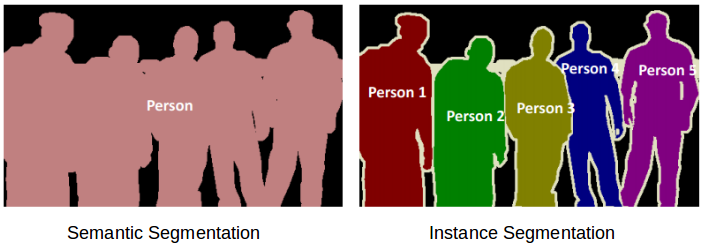

In [1]:
import os, random, cv2, glob
import numpy as np
from PIL import Image
import pandas as pd
import torch, torchvision
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

seed = 2048
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [2]:
print(torch.cuda.get_device_name(0)) 

Tesla T4


## Fix dataset issues, prepare annotations, remove unncessary files

This dataset has ~14000 images, ~7000 valid trimaps, ~3500 images with size above 224x224. So we take ~3500 images,trimaps,bboxes files and remove else.

In [ ]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# # extract data
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xzf /content/annotations.tar.gz
# !tar -xzf /content/images.tar.gz

In [12]:
# remove corrupted images

ROOT_DIR = '/content/images/'
images_paths = glob.glob('/content/images/*.jpg')

for i in images_paths:
  img = cv2.imread(i)
  try:
    if img.shape is not None:
        pass
  except:
    os.remove(i)
    print(i,"removed")  
print('Total images', len(images_paths))

# dont consider images below 224

images_paths = glob.glob('/content/images/*.jpg')
a = 224
b = 224
new_image_paths = []

for i in images_paths:
  img = cv2.imread(i)
  if img.shape[0] < a:
    os.remove(i)
    continue
  if img.shape[1] < b:
    os.remove(i) 
    continue
  new_image_paths.append(i)
print("New images count", len(new_image_paths)) 

# grab image_ids from paths

image_ids = []
for i in new_image_paths:
  temp_txt = i[::-1]
  for id, _ in enumerate(temp_txt):
    if temp_txt[id] == '/': 
      image_ids.append(temp_txt[:id][::-1][:-4])
      break

# remove ones withouts xml(bboxes)

new_image_ids = []
xmls_names = [a[:-4] for a in os.listdir("/content/annotations/xmls")]
for a in image_ids:
  if a in xmls_names:
    new_image_ids.append(a)  

# make labels

labels = []
for i in new_image_ids:
  temp_txt = i[::-1]
  for id, _ in enumerate(temp_txt):
    if temp_txt[id] == '_': 
      labels.append(temp_txt[id+1:][::-1])
      break
      
# make labels id

lb = pd.Series(labels)
lb = pd.factorize(lb, )
labels_id = lb[0]+1

# prepare bboxes 

xmin = []
ymin = []
xmax = []
ymax = []

xmls = os.listdir("/content/annotations/xmls")
for x in xmls:
  root = ET.parse("/content/annotations/xmls/"+ x).getroot()
  id = root.find('./filename').text[:-4]
  if id in new_image_ids:
    for a in root.findall('.//bndbox'):
      a = list(a)
      xmin.append(int(a[0].text))
      ymin.append(int(a[1].text))
      xmax.append(int(a[2].text))
      ymax.append(int(a[3].text))
      break

df = pd.DataFrame({
    'image_id': new_image_ids,
    'labels' : labels,
    'labels_id' : labels_id,
    'xmin': xmin,
    'ymin': ymin,
    'xmax': xmax,
    'ymax': ymax})

del xmls
del image_ids
del xmls_names
del labels
del labels_id
del images_paths
del new_image_paths
del xmin,ymin,xmax,ymax
print("Total images for training", df.image_id.count())

# remove uncessary trimaps, xmls

trimaps = [a[:-4] for a in os.listdir("/content/annotations/trimaps")]
images = [a[:-4] for a in os.listdir("/content/images")]

print(len(trimaps), len(images))

for im_id in images:
  if im_id not in new_image_ids:
    os.remove("/content/images/"+im_id+".jpg")  

for tri_id in trimaps:
  if tri_id not in new_image_ids:
    os.remove("/content/annotations/trimaps/"+tri_id+".png")

print(len(os.listdir("/content/annotations/trimaps")), len(os.listdir("/content/images")))
print("cleaned")    

Total images 7099
New images count 7099
Total images for training 3502


In [42]:
# make dataset zip 
!tar -zcf archive.tar.gz /content/cleaned-oxford-pets-dataset/

tar: Removing leading `/' from member names


## Copy dataset from gdrive

In [7]:
# copy dataset from drive

a = '/cleaned-oxford-pets-dataset.tar.gz'
b = '/content/drive/MyDrive/Datasets/cleaned-oxford-pets-dataset.tar.gz'

import shutil
shutil.copyfile(b,a)

!tar -xzf /content/cleaned-oxford-pets-dataset.tar.gz

In [2]:
new_image_ids = [a[:-4] for a in os.listdir("/content/content/cleaned-oxford-pets-dataset/images")]
df = pd.read_csv("/content/content/cleaned-oxford-pets-dataset/df.csv")
df = df.drop('Unnamed: 0', axis=1)
df.head()

,image_id,labels,labels_id,xmin,ymin,xmax,ymax
0,boxer_120,boxer,1,253,97,371,175
1,Birman_185,Birman,2,189,77,318,212
2,english_cocker_spaniel_141,english_cocker_spaniel,3,25,9,208,183
3,boxer_124,boxer,1,168,48,306,206
4,miniature_pinscher_160,miniature_pinscher,4,229,36,315,132


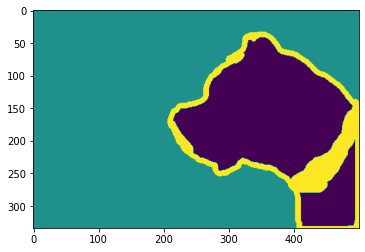

In [47]:
# mask sample
masks_path = '/content/content/cleaned-oxford-pets-dataset/trimaps/'
masks = [masks_path+a for a in os.listdir(masks_path)[:10]]
mask = cv2.imread(masks[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(np.array(mask) / 2 * 255 )
plt.show()

In this trimap we have 3 annotations, 1 "pet", 2 "background", 3 "border". In MaskRCNN we need only pet's mask, so we'll not consider 2 and 3.

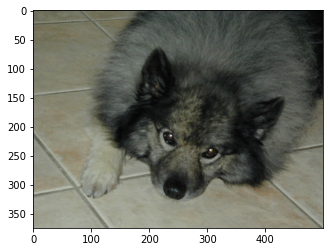

In [48]:
# image sample
imgs_path = '/content/content/cleaned-oxford-pets-dataset/images/'
images = [imgs_path+ a for a in os.listdir(imgs_path)[:10]]
image = Image.open(images[0])
plt.imshow(image)
plt.show()

## Prepare Dataset

Note: Masks(trimaps) should have class values from 1 and same for labels. 0 class is for background, so masks values should be from 1 and above and labels also from 1 to N.

In [3]:
# create dataset

class PetsDataset(Dataset):

  def __init__(self, annotations_df, image_ids, transform=None):
    self.image_ids = image_ids # imgs are jpg, masks are png
    self.annotations = annotations_df
    self.transform = transform
    self.image_size = [224,224]

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image = cv2.imread("/content/content/cleaned-oxford-pets-dataset/images/" + image_id +'.jpg', cv2.COLOR_BGR2RGB)

    mask = cv2.imread("/content/content/cleaned-oxford-pets-dataset/trimaps/"+ image_id +'.png', cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (self.image_size[0], self.image_size[1]), interpolation = cv2.INTER_NEAREST)

    # instances are encoded as different colors(eg 1,2,3)
    obj_ids = np.unique(mask)
    # in this trimaps 1 "pet", 2 "background", 3 "border", so we remove 2,3
    obj_ids = obj_ids[:1]
    # split the color-encoded mask into a set of binary masks
    masks = mask == obj_ids[:, None, None]

    anno = self.annotations[self.annotations['image_id'] == image_id]
    x1 = anno['xmin'].values
    y1 = anno['ymin'].values
    x2 = anno['xmax'].values
    y2 = anno['ymax'].values
    boxes = torch.as_tensor([[x1, y1, x2, y2]], 
                            dtype=torch.float32)
      
    labels = torch.from_numpy(anno['labels_id'].values)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
    area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((1,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    
    target = {}
    target['area'] = area
    target['labels'] = labels
    target['iscrowd'] = iscrowd
    target["image_id"] = torch.tensor([index])
    target["masks"] = masks

    image = self.transform(image)

    target['boxes'] = boxes.reshape(-1, 4) # recheck boxes dimension due to error
    
    return image, target

In [4]:
BATCH_SIZE = 32
x_train, x_test = train_test_split(new_image_ids, test_size=0.2, random_state=seed)

def collate_fn(batch):
    return tuple(zip(*batch))

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([224, 224])])

train_dataset = PetsDataset(df, x_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = PetsDataset(df, x_test, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 2804 and Test Dataset 701


In [12]:
# test output
val_dataset[100][0].shape, val_dataset[100][1]['masks'].shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

## Prepare Model

Model1 (Original Renset50FPN)

In [ ]:
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# num_classes = 38
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                     hidden_layer,
#                                                     num_classes)

Model2 (Resnet18FPN)

In [5]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

num_classes = 38
backbone = resnet_fpn_backbone('resnet18', pretrained=True)
model = MaskRCNN(backbone, num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

print("Total trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))

Total trainable parameters 30934003


In [ ]:
# # test model output

# images, targets = next(iter(train_loader))
# model.train()
# model.cuda(0)
# images = list(image.cuda(0) for image in images)
# targets = [{k: v.cuda(0) for k, v in t.items()} for t in targets]
# loss_dict = model(images, targets)
# sum(loss for loss in loss_dict.values())

## Training

In [6]:
# metric

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [7]:
# training

def train_model(model, EPOCHS, optimizer, scheduler, BATCH_SIZE, train_loader, val_loader):

  TRAIN_LOSS = []
  VAL_LOSS = []
  MIN_LOSS = 20.0
  model_save_path = '/content/pet_finder.bin'

  scaler = torch.cuda.amp.GradScaler()
  loss_hist = Averager()

  for epoch in range(1, EPOCHS+1):
    print("Epoch", epoch)
    model.train()
    for (images, targets) in train_loader:
      
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      with torch.cuda.amp.autocast():
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_hist.send(losses.item())
      scaler.scale(losses).backward()
      scaler.step(optimizer)
      scaler.update()
      optimizer.zero_grad()

    train_l = loss_hist.value
    TRAIN_LOSS.append(train_l)
    total = 0
    correct = 0 
    print("Training Loss:", train_l)
    loss_hist.reset()
    # model.eval()

    for (images, targets) in val_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      with torch.no_grad():
        loss_dict = model(images, targets)
      val_loss = sum(loss for loss in loss_dict.values())
      loss_hist.send(val_loss.item())

    valid_l = loss_hist.value
    print("Val Loss:", valid_l)
    VAL_LOSS.append(valid_l)

    if scheduler is not None:
      scheduler.step()

    if MIN_LOSS > min(VAL_LOSS):
      MIN_LOSS = min(VAL_LOSS)
      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, model_save_path)
      print('Model Saved...')
  return VAL_LOSS, TRAIN_LOSS  

In [9]:
%%time

LR = 0.001
EPOCHS = 1
device = 'cuda:0'
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)

val_loss, train_loss = train_model(model, EPOCHS, optimizer, lr_scheduler, 
                                            BATCH_SIZE, train_loader, val_loader)

Epoch 1
Training Loss: 1.31924146278338
Val Loss: 1.0601754540746862
Model Saved...
CPU times: user 2min 33s, sys: 1min 35s, total: 4min 9s
Wall time: 4min 9s


## Training curves

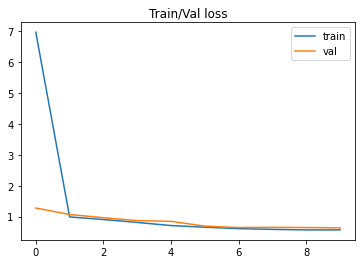

In [ ]:
# training curves

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Train/Val loss')
plt.show()

## Results

In [ ]:
model.load_state_dict(torch.load('/content/pet_finder.bin')['model_state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()
images, targets = next(iter(val_loader))
images = list(image.cuda(0) for image in images)
targets = [{k: v.cuda(0) for k, v in t.items()} for t in targets]
with torch.no_grad():
    prediction = model([images[0]])

In [ ]:
prediction[0]

{'boxes': tensor([], device='cuda:0', size=(0, 4)),
 'labels': tensor([], device='cuda:0', dtype=torch.int64),
 'masks': tensor([], device='cuda:0', size=(0, 1, 224, 224)),
 'scores': tensor([], device='cuda:0')}

Note: Predictions are empty because model has not converged, more training will make results appear.

Summary: This dataset gave me really hard time in cleaning and preparing. If everything is right results should appear after ~15.